In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fftpack,signal
import matplotlib
from matplotlib.ticker import ScalarFormatter
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval)
import scipy
import json
import subprocess
import os
import emcee
import tqdm
import corner

from exocrires import spectra_2d
from exocrires import analysis
from exocrires import info
from exocrires import extinction_fitting

import PyMieScatt as scatt

In [2]:
path='/Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/thesis_ms'
filenames=glob.glob(path+'/models_1683734698/bt-settl/lte*')
filenames=sorted(filenames)

sum_bt_settl=np.zeros((len(filenames),2, 395708))
i=0

for filename in filenames:
    data=np.loadtxt(filename)
    data[:,0]=data[:,0] #angstrom
    
    data_array=np.array((data[:,0], data[:,1]))
    sum_bt_settl[i][0:data_array.shape[0], 0:data_array.shape[1]]=data_array
    
    i+=1

In [3]:
sum_bt_settl[-6]

array([[0.00000e+000, 1.00000e-003, 2.00000e-003, ..., 9.98227e+006,
        9.98727e+006, 9.99227e+006],
       [5.48681e-100, 5.48681e-100, 5.48681e-100, ..., 5.14147e-006,
        5.13218e-006, 5.12215e-006]])

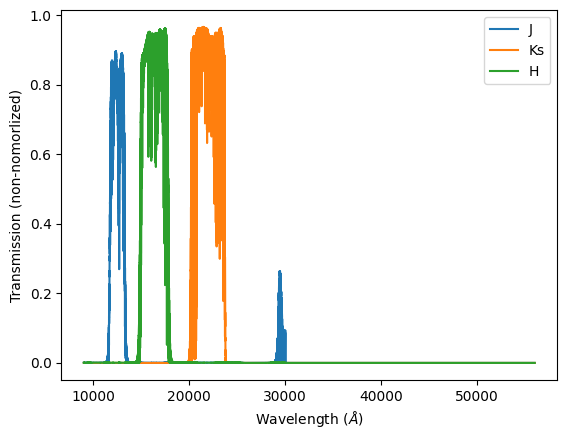

In [4]:
r_j = 6.9950e9
r_sun = 6.957e10
pc = 3.086e18
AU=1.496e13

path_0='/Users/richard/Library/CloudStorage/OneDrive-AlmaMaterStudiorumUniversitàdiBologna/project_EXOCRIRES/AB_Aur'

#read the transmission files

#-----J-----
band_j = np.loadtxt(path_0+'/J_tottrans.dat',skiprows=1)
#band_j=np.sort(band_j, axis=0)
band_j=np.array((band_j[:,0]*10, band_j[:,1]))
b_j=[band_j[0].min(),band_j[0].max()]

plt.plot(band_j[0], band_j[1], label='J')
plt.ylabel('Transmission (non-nomorlized)')
plt.xlabel('Wavelength ($\AA$)')

#----K-----
band_k = np.loadtxt(path_0+'/K_tottrans.dat',skiprows=1)
#band_kp=np.sort(band_kp, axis=0)
band_k=np.array((band_k[:,0]*10, band_k[:,1]))
b_k=[band_k[0].min(),band_k[0].max()]

plt.plot(band_k[0], band_k[1], label='Ks')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Transmission (non-nomorlized)')


#----H-----
band_bh = np.loadtxt(path_0+'/H_tottrans.dat')
band_h=np.array((band_bh[:,0]*10, band_bh[:,1]))
b_h=[band_h[0].min(),band_h[0].max()]

plt.plot(band_h[0], band_h[1], label='H')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Transmission (non-nomorlized)')

plt.legend()



#zero-point flux 
c=scipy.constants.speed_of_light

zero_flux_j=3.06e-10 #(erg/cm2/s/A)
zero_flux_k=4.08e-11 #(erg/cm2/s/A), Ks
zero_flux_h=1.188e-10 #(erg/cm2/s/A), B_H
#zero_flux_y=5.5671e-10

#apparent magnitude
mag_j=[15.15, 0.19]
mag_h=[14.56, 0.18]
mag_k=[14.01, 0.21]

plt.savefig(path_0+'/filter.png', dpi=100)
plt.show()

In [5]:
def flux_retrieve(magnitude, zero_point, mag_error):

    mag=np.array([magnitude-mag_error, magnitude, magnitude+mag_error])

    F=zero_point*(10**((-mag/2.5)))


    return (F)

F_obs_jhk=np.zeros(shape=(3,3))
zero_flux=np.array([zero_flux_j, zero_flux_h, zero_flux_k])
apparent_mag=np.array([mag_j, mag_h, mag_k])

for i in range(F_obs_jhk.shape[0]):
    
    F_obs=flux_retrieve(apparent_mag[i][0], zero_flux[i], apparent_mag[i][1])

    F_obs_jhk[i]=F_obs

print (F_obs_jhk)

print(F_obs_jhk[:,0]-F_obs_jhk[:,1])
print(F_obs_jhk[:,1]-F_obs_jhk[:,2])

[[3.17483695e-16 2.66514859e-16 2.23728560e-16]
 [2.10288944e-16 1.78162558e-16 1.50944204e-16]
 [1.23214030e-16 1.01545379e-16 8.36874169e-17]]
[5.09688367e-17 3.21263858e-17 2.16686516e-17]
[4.27862990e-17 2.72183548e-17 1.78579617e-17]


In [12]:
band_range=np.array((b_j, b_h, b_k))
trans=[band_j, band_h, band_k]
band_center=np.array([12437.52, 16259.01, 21815.98])

err=F_obs_jhk[:,1]-F_obs_jhk[:,2]

f=np.load(path_0+'/f_pRT_t2200_g31nc_m0.0.npy')*1e-8
#f=sum_bt_settl[-6][1]
lam=np.load(path_0+'/wave_pRT_4.npy')*1e4
#lam=sum_bt_settl[-6][0]

fit=extinction_fitting.extinction_fitting(wavelength_sed=lam, flux_sed=f, flux_obs=F_obs_jhk[:,1], flux_obs_err=err, extinction_law='ISM',\
                       radius_range=np.arange(0.01,10,0.01)*r_j, av_range=np.arange(0, 50, 0.1), band_center=band_center, beta=-2.07)

F_rec_jhk=np.zeros(shape=(3,))
F_int_jhk=np.zeros(shape=(3,))

F=fit.Flux_integral(band_border=band_range, transmission=trans)

  0%|                                                  | 0/2000 [00:00<?, ?it/s]/Users/richard/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████| 2000/2000 [00:08<00:00, 228.72it/s]


(194000, 2)


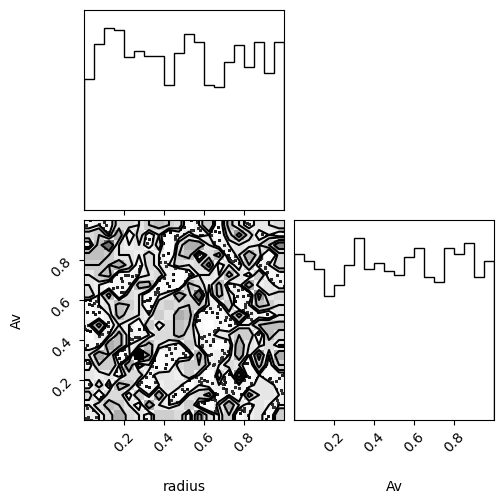

In [13]:
# Set up the MCMC sampler
n_walkers = 2000  # Number of walkers
n_params = 2   # Number of parameters
n_steps = 2000

# Initialize walkers with random starting points
initial_positions = np.random.rand(n_walkers, n_params)

#Set up the array for best-fitting parameters and other arguments 
best_fitting_params_3=np.zeros((n_params+1))

flat_sam, best_fti_params=fit.MCMC(n_walkers, n_steps, n_params, ['radius', 'Av'],\
                                   lower_bounds=np.array([fit.radius_range.min(), fit.av_range.min()]),\
                                   upper_bounds=np.array([fit.radius_range.max(), fit.av_range.max()]),\
                                  dis=155.9*pc)

